# Zero-Adjusted Gamma Regression

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/LightGBMLSS/blob/master/docs/examples/ZAGamma_Regression.ipynb)

# Imports

In [2]:
from lightgbmlss.model import *
from lightgbmlss.distributions.ZAGamma import *

from sklearn.model_selection import train_test_split 
import pandas as pd
import plotnine
from plotnine import *
plotnine.options.figure_size = (18, 9)

# Data

In [3]:
# The simulation example closely follows https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af
np.random.seed(123)
n_samples = 1000

data = pd.DataFrame({"age": np.random.randint(1, 100, size=n_samples)})
data["income"] = np.where((data.age > 17) & (data.age < 70), 1500*data.age + 5000 + 10000*np.random.randn(n_samples), 0) / 1000

y = data["income"].values
X = data.drop(columns="income")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = lgb.Dataset(X_train, label=y_train)

# Distribution Selection

In [4]:
# Specifies Zero-Adjusted Gamma distribution. See ?ZAGamma for an overview.
lgblss = LightGBMLSS(
    ZAGamma(stabilization="None",        # Options are "None", "MAD", "L2".
            response_fn="exp",           # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
            loss_fn="nll"                # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).)      
           )           
)

# Hyper-Parameter Optimization

Any LightGBM hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"boosting": ["categorical", ["gbdt", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

In [5]:
param_dict = {
    "eta":                      ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":                ["int",   {"low": 1,      "high": 10,    "log": False}],
    "min_gain_to_split":        ["float", {"low": 1e-8,   "high": 40,    "log": False}],
    "min_sum_hessian_in_leaf":  ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "subsample":                ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "feature_fraction":         ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "boosting":                 ["categorical", ["gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=20,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-08-11 12:13:43,049] A new study created in memory with name: LightGBMLSS Hyper-Parameter Optimization


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-08-11 12:13:46,907] Trial 0 finished with value: 493.3361578406364 and parameters: {'eta': 0.0003914367990686954, 'max_depth': 8, 'min_gain_to_split': 33.26852906521015, 'min_sum_hessian_in_leaf': 0.08584812980967063, 'subsample': 0.8021623973944538, 'feature_fraction': 0.8005070720671894, 'boosting': 'gbdt'}. Best is trial 0 with value: 493.3361578406364.
[I 2023-08-11 12:13:47,643] Trial 1 finished with value: 471.35372890681646 and parameters: {'eta': 0.40295767323333237, 'max_depth': 10, 'min_gain_to_split': 24.549932527360678, 'min_sum_hessian_in_leaf': 256.4870626827937, 'subsample': 0.8683684494312434, 'feature_fraction': 0.7849944406887219, 'boosting': 'gbdt'}. Best is trial 1 with value: 471.35372890681646.
[I 2023-08-11 12:13:51,060] Trial 2 finished with value: 503.6348357284388 and parameters: {'eta': 1.222371366077261e-05, 'max_depth': 4, 'min_gain_to_split': 28.061063870566468, 'min_sum_hessian_in_leaf': 0.0007422808244019155, 'subsample': 0.5522281492920988, 'fea

C:\Users\maerzale\.virtualenvs\LightGBMLSS--u9b4l4T\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract


[I 2023-08-11 12:14:10,085] Trial 9 finished with value: 435.35091073184594 and parameters: {'eta': 0.9428989545188251, 'max_depth': 10, 'min_gain_to_split': 4.488114462250434, 'min_sum_hessian_in_leaf': 1.7998195761788722, 'subsample': 0.29209480384149383, 'feature_fraction': 0.9592081048531047, 'boosting': 'gbdt'}. Best is trial 5 with value: 401.0408565228521.
[I 2023-08-11 12:14:11,097] Trial 10 finished with value: 469.6566333865485 and parameters: {'eta': 0.20312012140237876, 'max_depth': 7, 'min_gain_to_split': 12.765970540892038, 'min_sum_hessian_in_leaf': 167.938324975031, 'subsample': 0.7047234963516413, 'feature_fraction': 0.26898548607003475, 'boosting': 'gbdt'}. Best is trial 5 with value: 401.0408565228521.
[I 2023-08-11 12:14:14,892] Trial 11 finished with value: 410.651136877749 and parameters: {'eta': 0.016887194634392852, 'max_depth': 1, 'min_gain_to_split': 16.11709690117341, 'min_sum_hessian_in_leaf': 7.572146181609595e-08, 'subsample': 0.9978336630147084, 'feature_

# Model Training

In [6]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [7]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
# Quantiles to calculate from predicted distribution
quant_sel = [0.05, 0.95] 

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [8]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.516289,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,60.929550,105.531929,64.138367,110.538750,83.007111,65.914368,114.569489,83.754181,76.929359,106.249832,...,126.694046,58.902824,106.914062,109.303070,64.697182,71.515106,96.678009,93.943962,62.027760,0.000000
2,37.353783,32.012577,31.435833,38.747078,74.590515,53.662891,22.332142,55.751812,19.008478,32.330696,...,0.000000,28.788361,22.363855,16.031998,38.852062,25.945065,30.270662,23.981115,37.747807,25.279463
3,30.415985,51.455875,47.262981,56.843914,75.915627,90.310211,78.174225,73.345291,48.665390,84.060516,...,35.612038,56.444321,64.669716,63.445686,94.317162,33.868572,28.650946,30.990072,83.390099,59.522594
4,0.000000,0.000000,0.000000,23.404318,0.000000,46.938168,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,0.0,77.157624
1,0.0,133.450491
2,0.0,51.579050
3,0.0,91.223141
4,0.0,24.037125


In [10]:
pred_params.head()

,concentration,rate,gate
0,13.424025,0.149034,0.943975
1,13.424025,0.149034,0.054856
2,9.111379,0.275753,0.054856
3,9.111379,0.158935,0.054856
4,9.111379,0.275753,0.943975


# SHAP Interpretability

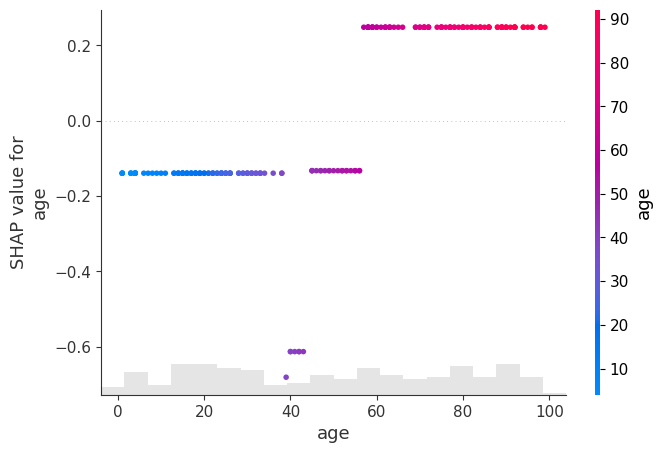

In [11]:
# Partial Dependence Plot of concentration parameter
lgblss.plot(X_test,
            parameter="concentration",
            feature="age",
            plot_type="Partial_Dependence")

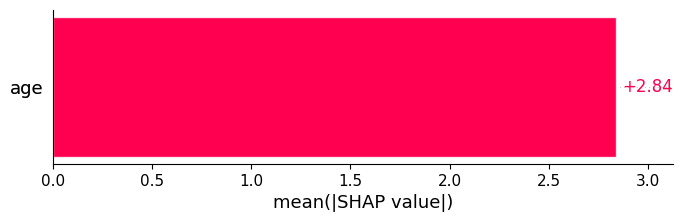

In [12]:
# Feature Importance of gate parameter
lgblss.plot(X_test,
            parameter="gate",
            plot_type="Feature_Importance")

# Density Plots of Actual and Predicted Samples

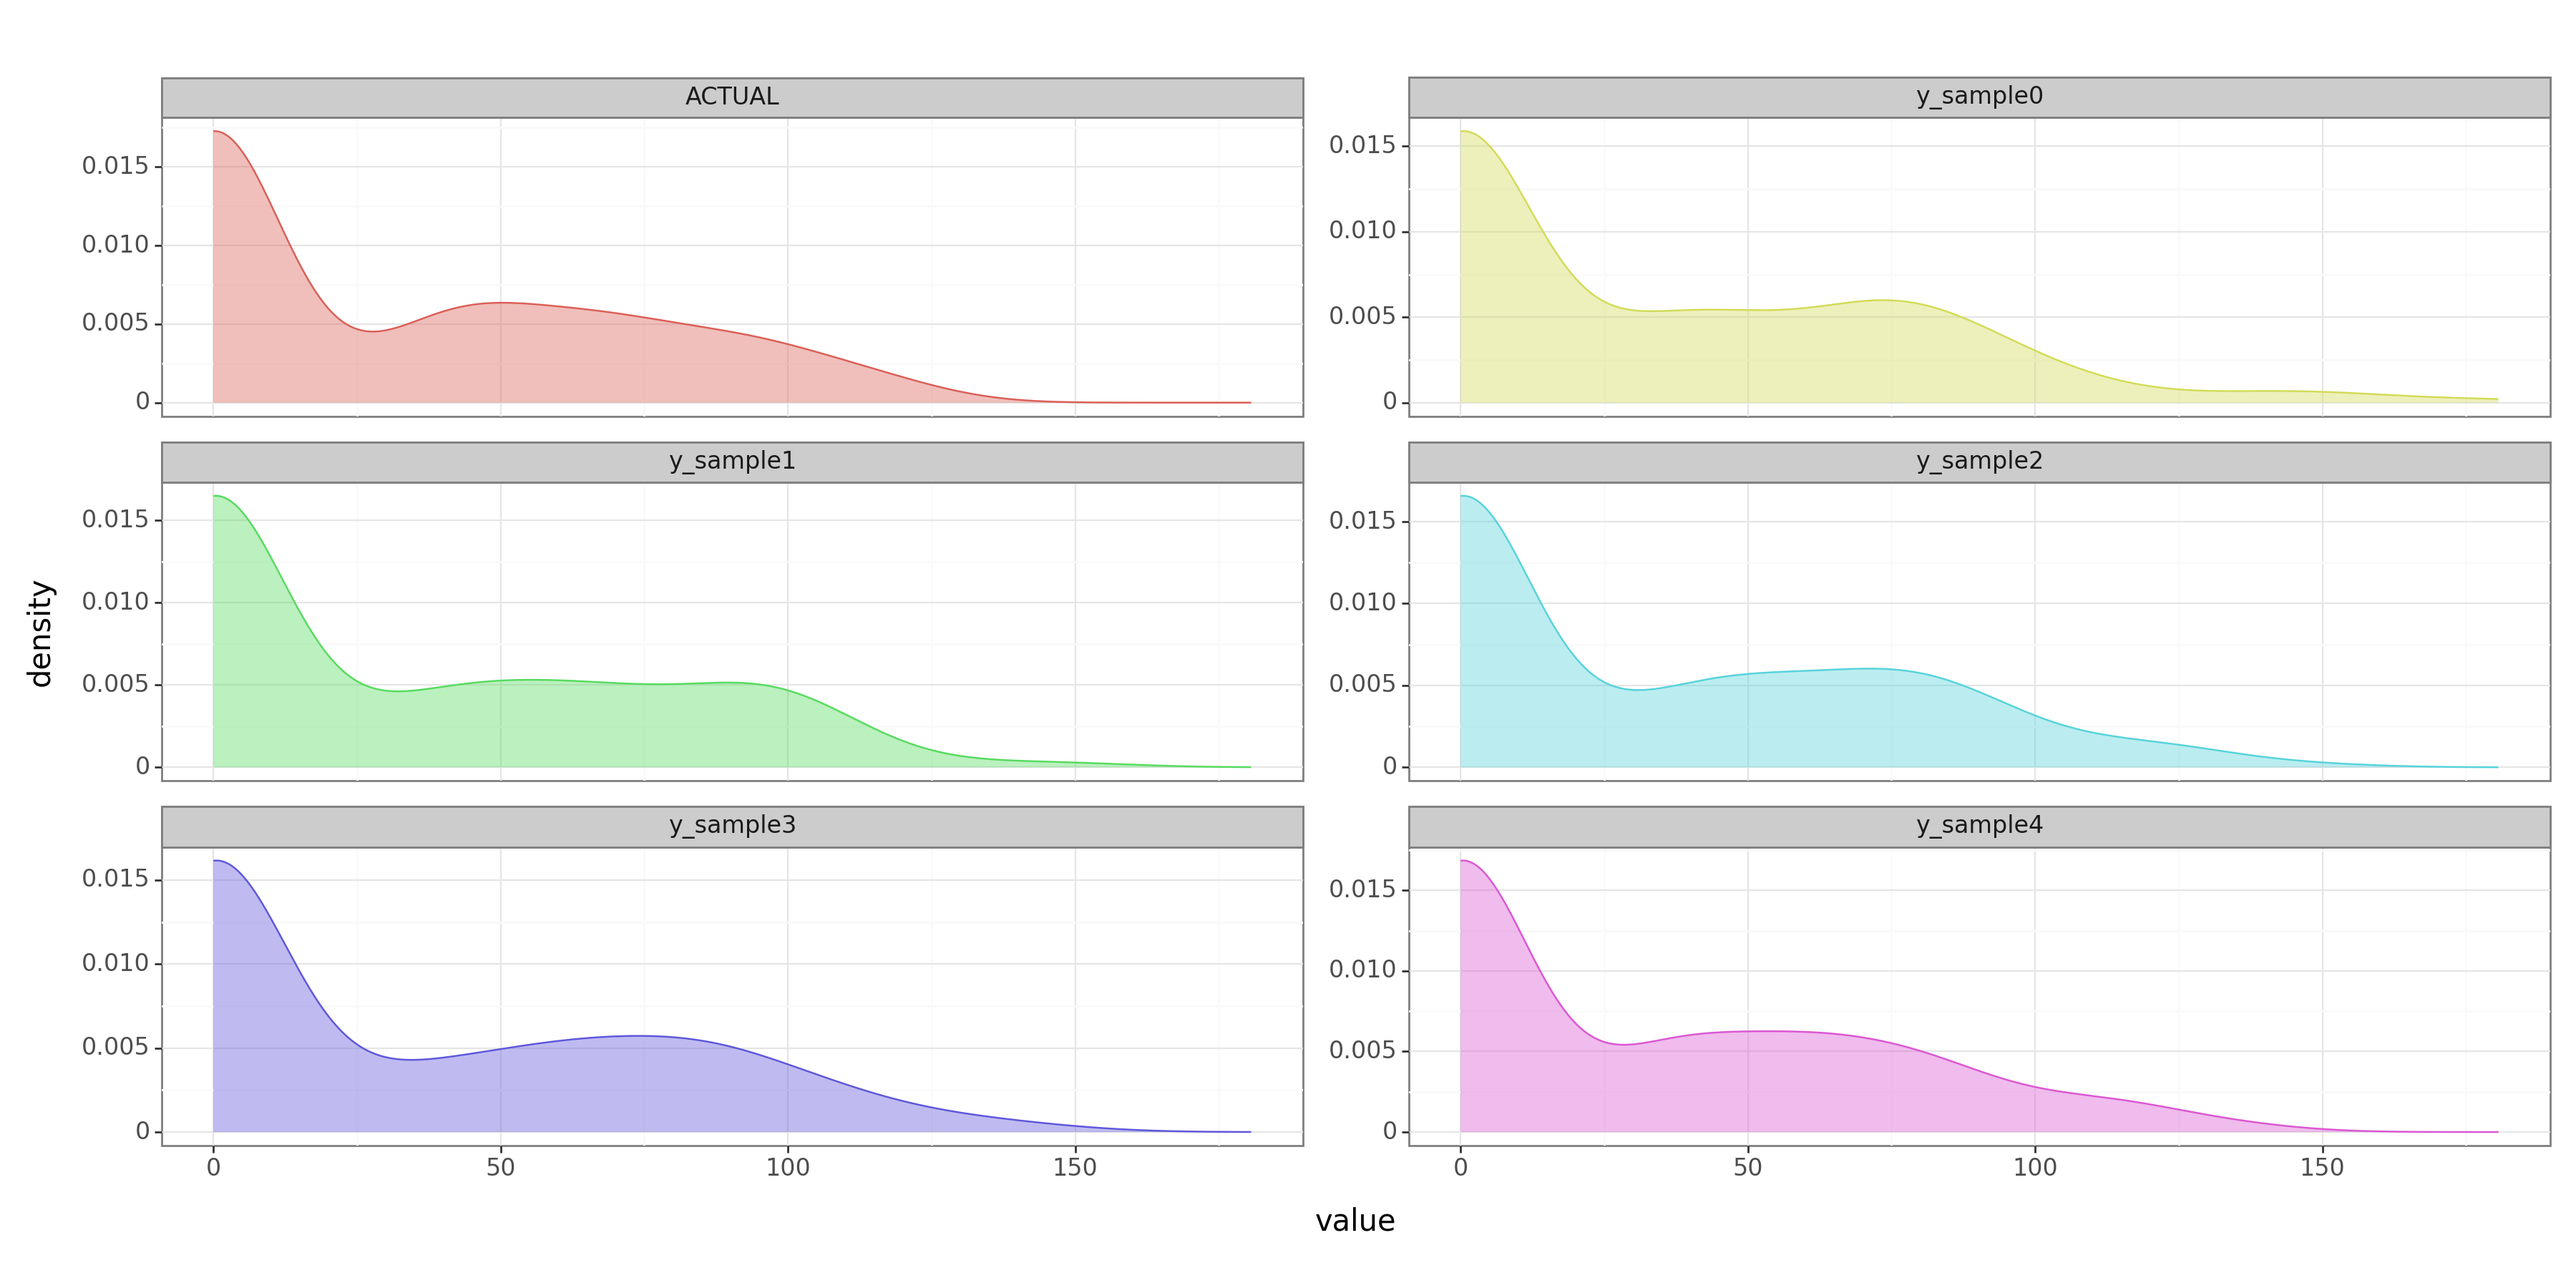

<Figure Size: (1800 x 900)>

In [13]:
pred_df = pd.melt(pred_samples.iloc[:,0:5])
actual_df = pd.DataFrame.from_dict({"variable": "ACTUAL", "value": y_test.reshape(-1,)})
plot_df = pd.concat([pred_df, actual_df])

(
    ggplot(plot_df, 
           aes(x="value",
               color="variable",
               fill="variable")) +  
    geom_density(alpha=0.4) + 
    facet_wrap("variable",
              scales="free_y",
              ncol=2) + 
    theme_bw(base_size=15) + 
    theme(legend_position="none")
)